In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.3f}'.format


In [3]:
df=pd.read_excel('cust_360_final.xlsx')

In [4]:
df.head()

,USER_ID,Gender,first_Date,recent_date,Customer_value,buy_times,Points_earned,Points_redeemed,no_baskets,qty,...,pct_pur_w_promo_prds,buyer_flag,multi_cat_flag,redeem_flag,Promo_seeker_flag,Decile_Sale_amt,Decile_Margin,CustomerSegment,High_Spender_flag,Churn_flag
0,347,F,20120130,20130328,444.000,4,457,NaN,3,35,...,NaN,Repeat Buyer,0,0,1,0,6,UpwardMigrator,0,0
1,885,M,20120412,20121206,2284.580,7,1715,15400.000,4,247,...,1.000,Repeat Buyer,1,1,1,7,8,DownWardMigrator,0,0
2,1670,M,20120708,20130328,8092.170,29,3030,29455.000,28,553,...,0.860,Repeat Buyer,1,1,1,9,9,UpwardMigrator,1,0
3,4468,M,20120119,20130308,2428.630,11,743,900.000,7,63,...,0.570,Repeat Buyer,1,1,0,6,1,DownWardMigrator,0,0
4,4682,F,20120213,20121221,2037.020,10,1100,NaN,4,307,...,0.750,Repeat Buyer,1,0,0,4,7,DownWardMigrator,0,0


## Feature Engineering


- First the features are selected based on common knowledge.
- Also utilized correlation test between categorical variables and target as a part of the feature selection. 

In [5]:
imp_cat_features_condition=(df.loc[:,df.columns.str.contains('cat_prod',case=False)].corrwith(df['sale_amount'])>0.15).reset_index()
imp_cat_features=imp_cat_features_condition[imp_cat_features_condition[0]==True]['index'].values
imp_cat_features

array(['cat_prod_cnt_Beauty', 'cat_prod_cnt_Drinks', 'cat_prod_cnt_Food',
       'cat_prod_cnt_HH_Electrical', 'cat_prod_cnt_Home',
       'cat_prod_cnt_Kitchen_Clean', 'cat_prod_cnt_Mobiles',
       'cat_prod_cnt_Mother_Child'], dtype=object)

- same categories are considered for their penetration info per customer 

In [6]:
df_new=df[['USER_ID',
           
# Product level features           
           'No_SKUs', 'No_Distinct_SKUs', 
# Category level features
           'No_categories','No_Distinct_categories',
# Total cost of all the products purchased            
           'cost_amt','qty', 
# Basket related features       
       'no_baskets','no_baskets_weekend', 'no_baskets_weekday', 'no_baskets_No_promo',
       'no_baskets_Promo', 'no_Promo_prods',
# Discount related features       
       'discount','Products_with_discount','Products_without_discount',
       
# Category wise product orders related features       
       'cat_prod_cnt_Beauty', 'cat_prod_cnt_Drinks', 'cat_prod_cnt_Food',
       'cat_prod_cnt_HH_Electrical', 'cat_prod_cnt_Home',
       'cat_prod_cnt_Kitchen_Clean', 'cat_prod_cnt_Mobiles',
       'cat_prod_cnt_Mother_Child',
# category penetration related features      
       'cat_pen_Beauty','cat_pen_Drinks','cat_pen_Food', 'cat_pen_HH_Electrical', 'cat_pen_Home',
       'cat_pen_Kitchen_Clean', 'cat_pen_Mobiles','cat_pen_Mother_Child',
# Some key factors that can help explain variability in sales_amount
       'Gender','buy_times','CustomerSegment',
# Target variable       
       'sale_amount'
       ]]

Now we will check all features correlation with target variables and further check if i should remove further.

- So out of 117 features i haveselected 36 features. The sole aim was to avoid redundant features as well as avoid multicollinearity as much as i can.

In [9]:
# Since this is a ordinal categorical variable therefore will perform spearmanr correlation test 
# for its importance in explaining variability in sales_amount
C_S_corr=df_new[~df_new['CustomerSegment'].isnull()]

In [10]:
from scipy.stats import spearmanr,pointbiserialr

spearman_corr, p_value = spearmanr(C_S_corr['CustomerSegment'], C_S_corr['sale_amount'])

print("Spearman Rank Correlation Coefficient:", spearman_corr)
print("P-value:", p_value)

Spearman Rank Correlation Coefficient: 0.037063671252934305
P-value: 0.001387256153566618


- So the rank correlation between customer segment (which is ordinal cat col) and target variable is statistically significant but the association between the two is very weak. Therefore i am dropping this column.
 

 Lets now decide the other two cat var which are nominal (binary)
- For binary indep var and cont dep var Point-Biserial Correlation coefficient this test is generally prefered. 

In [9]:
df_new.Gender.value_counts()

M          4092
F          2030
unknown    1318
Name: Gender, dtype: int64

In [ ]:
gender_corr=df_new[~(df_new.Gender=='unknown')]
gender_corr['Gender']=gender_corr.Gender.apply(lambda x: 1 if x=='M' else 0)


In [13]:
gender_corr.Gender.value_counts()

Gender
1    4092
0    2030
Name: count, dtype: int64

In [14]:
point_biserial_corr, p_value = pointbiserialr(gender_corr['Gender'], gender_corr['sale_amount'])

print("Point-Biserial Correlation Coefficient:", point_biserial_corr)
print("P-value:", p_value)

Point-Biserial Correlation Coefficient: -0.0026959751052857417
P-value: 0.8329660402986964


- So no meaningful correlation between the gender of the customer and total sales.

So basically rejecting the gender as well as customer's segment info.

In [ ]:
df_new.drop(columns=['CustomerSegment','Gender'],inplace=True)

In [ ]:
# Also dropping user_id as it carries no weight in predicting the target
df_new.drop(columns='USER_ID',inplace=True)

In [19]:
df_new.shape

(7440, 33)

## Conditions check for Regression Analysis

### 1. Multicollinearity

In [23]:
# Handling null 
df_new=df_new.fillna(0)
df_new.isnull().sum()


No_SKUs                       0
No_Distinct_SKUs              0
No_categories                 0
No_Distinct_categories        0
cost_amt                      0
qty                           0
no_baskets                    0
no_baskets_weekend            0
no_baskets_weekday            0
no_baskets_No_promo           0
no_baskets_Promo              0
no_Promo_prods                0
discount                      0
Products_with_discount        0
Products_without_discount     0
cat_prod_cnt_Beauty           0
cat_prod_cnt_Drinks           0
cat_prod_cnt_Food             0
cat_prod_cnt_HH_Electrical    0
cat_prod_cnt_Home             0
cat_prod_cnt_Kitchen_Clean    0
cat_prod_cnt_Mobiles          0
cat_prod_cnt_Mother_Child     0
cat_pen_Beauty                0
cat_pen_Drinks                0
cat_pen_Food                  0
cat_pen_HH_Electrical         0
cat_pen_Home                  0
cat_pen_Kitchen_Clean         0
cat_pen_Mobiles               0
cat_pen_Mother_Child          0
buy_time

In [31]:
X=df_new.iloc[:,:-1]
y=df_new.iloc[:,-1]

In [79]:
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [80]:
# gather features from best_feature_IV
vif1 = pd.DataFrame()
def cal_vif(f,v):
    featuresn = df_new[f].columns
    featuresn = '+'.join(featuresn)
    featuresn = 'sale_amount~'+featuresn
    y, X_ = dmatrices(featuresn, df_new, return_type='dataframe')
    v = pd.DataFrame()
    v['VIF Factor'] = [variance_inflation_factor(X_.values, i) for i in range(X_.shape[1])]
    v['features'] = X_.columns
    return v.sort_values('VIF Factor',ascending=False)

In [81]:
features=list(df_new.columns.difference(['sale_amount']))
vif=cal_vif(features,vif1)
vif.head(10)


c:\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
27,inf,no_baskets
31,inf,no_baskets_weekend
3,inf,No_SKUs
4,inf,No_categories
5,inf,Products_with_discount
6,inf,Products_without_discount
30,inf,no_baskets_weekday
28,622.182,no_baskets_No_promo
1,18.903,No_Distinct_SKUs
7,18.528,buy_times


In [82]:
# Function for dropping variables

def drop_var(x):
    var = x.sort_values('VIF Factor',ascending=False)[-(x.features=='Intercept')].head(1).features.values[0]
    return var

#### Removing variables one by one till all variables' vif ~ 10 or vif <10

In [83]:
# 1.
print('Variable to be dropped:',drop_var(cal_vif(features,vif1)),'\n')
features.remove(drop_var(cal_vif(features,vif1)))
vif = cal_vif(features,vif1)
vif.head()


c:\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variable to be dropped: no_baskets 



c:\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
3,inf,No_SKUs
4,inf,No_categories
5,inf,Products_with_discount
6,inf,Products_without_discount
27,622.182,no_baskets_No_promo


In [84]:
# 2.

print('Variable to be dropped:',drop_var(cal_vif(features,vif1)),'\n')
features.remove(drop_var(cal_vif(features,vif1)))
vif = cal_vif(features,vif1)
vif.head()

c:\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variable to be dropped: No_SKUs 



c:\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
3,inf,No_categories
4,inf,Products_with_discount
5,inf,Products_without_discount
26,622.182,no_baskets_No_promo
28,399.384,no_baskets_weekday


In [85]:
# 3.

print('Variable to be dropped:',drop_var(cal_vif(features,vif1)),'\n')
features.remove(drop_var(cal_vif(features,vif1)))
vif = cal_vif(features,vif1)
vif.head()

c:\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variable to be dropped: No_categories 



c:\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
25,622.182,no_baskets_No_promo
27,399.384,no_baskets_weekday
28,74.066,no_baskets_weekend
4,44.616,Products_without_discount
1,18.903,No_Distinct_SKUs


In [86]:
# 4.

print('Variable to be dropped:',drop_var(cal_vif(features,vif1)))
features.remove(drop_var(cal_vif(features,vif1)))
vif = cal_vif(features,vif1)
vif.head()

Variable to be dropped: no_baskets_No_promo


,VIF Factor,features
4,44.002,Products_without_discount
1,18.771,No_Distinct_SKUs
5,18.295,buy_times
22,16.362,cost_amt
0,15.679,Intercept


In [87]:
# 5.

print('Variable to be dropped:',drop_var(cal_vif(features,vif1)))
features.remove(drop_var(cal_vif(features,vif1)))
vif = cal_vif(features,vif1)
vif.head()

Variable to be dropped: Products_without_discount


,VIF Factor,features
4,17.854,buy_times
21,16.354,cost_amt
0,15.534,Intercept
1,14.341,No_Distinct_SKUs
19,13.542,cat_prod_cnt_Mobiles


In [88]:
# 6.

print('Variable to be dropped:',drop_var(cal_vif(features,vif1)))
features.remove(drop_var(cal_vif(features,vif1)))
vif = cal_vif(features,vif1)
vif.head()

Variable to be dropped: buy_times


,VIF Factor,features
20,15.897,cost_amt
0,15.529,Intercept
18,13.514,cat_prod_cnt_Mobiles
1,12.847,No_Distinct_SKUs
23,10.255,no_baskets_Promo


In [89]:
# 7.

print('Variable to be dropped:',drop_var(cal_vif(features,vif1)))
features.remove(drop_var(cal_vif(features,vif1)))
vif = cal_vif(features,vif1)
vif.head()

Variable to be dropped: cost_amt


,VIF Factor,features
0,15.492,Intercept
1,12.741,No_Distinct_SKUs
22,10.241,no_baskets_Promo
20,9.338,discount
19,8.487,cat_prod_cnt_Mother_Child


In [90]:
# 8.

print('Variable to be dropped:',drop_var(cal_vif(features,vif1)))
features.remove(drop_var(cal_vif(features,vif1)))
vif = cal_vif(features,vif1)
vif.head()

Variable to be dropped: No_Distinct_SKUs


,VIF Factor,features
0,15.055,Intercept
21,9.758,no_baskets_Promo
19,8.724,discount
18,8.084,cat_prod_cnt_Mother_Child
22,6.243,no_baskets_weekday


In [91]:
vif

,VIF Factor,features
0,15.055,Intercept
21,9.758,no_baskets_Promo
19,8.724,discount
18,8.084,cat_prod_cnt_Mother_Child
22,6.243,no_baskets_weekday
20,4.817,no_Promo_prods
12,3.466,cat_prod_cnt_Drinks
13,3.441,cat_prod_cnt_Food
16,3.159,cat_prod_cnt_Kitchen_Clean
2,2.921,Products_with_discount


All features now have vif <=10

In [92]:
vif_features = vif[-(vif['features']=='Intercept')].features.values
print('No. of features:',len(vif_features))
vif_features

No. of features: 24


array(['no_baskets_Promo', 'discount', 'cat_prod_cnt_Mother_Child',
       'no_baskets_weekday', 'no_Promo_prods', 'cat_prod_cnt_Drinks',
       'cat_prod_cnt_Food', 'cat_prod_cnt_Kitchen_Clean',
       'Products_with_discount', 'cat_prod_cnt_Beauty',
       'No_Distinct_categories', 'qty', 'cat_prod_cnt_Home',
       'cat_prod_cnt_HH_Electrical', 'no_baskets_weekend',
       'cat_pen_Kitchen_Clean', 'cat_pen_HH_Electrical', 'cat_pen_Drinks',
       'cat_pen_Beauty', 'cat_pen_Food', 'cat_pen_Home',
       'cat_pen_Mother_Child', 'cat_prod_cnt_Mobiles', 'cat_pen_Mobiles'],
      dtype=object)

### 2. Linear Relationship with target

In [93]:
X1=df_new[vif_features]
X1.shape

(7440, 24)

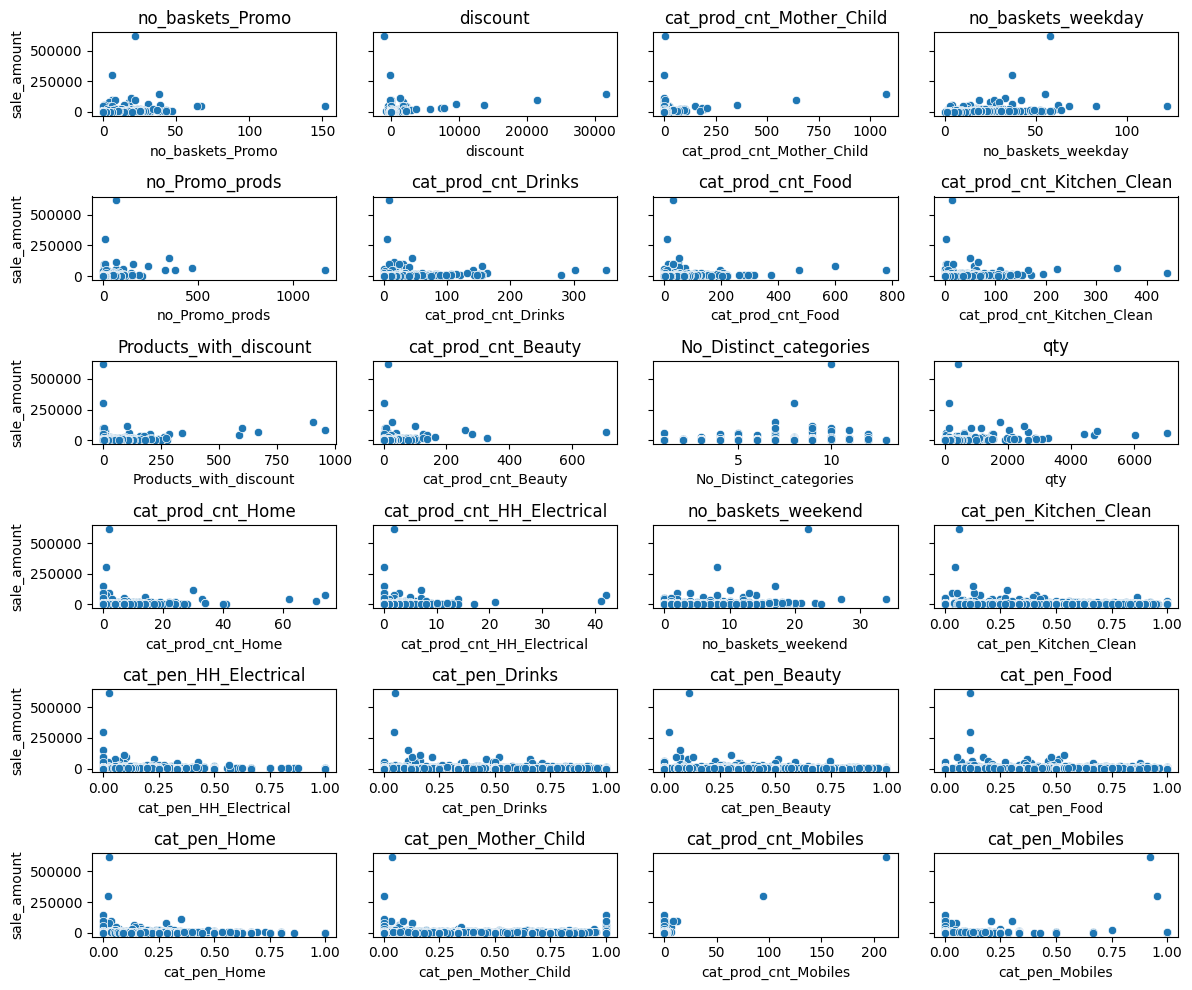

In [94]:
fig, axes = plt.subplots(nrows=6,ncols=4,sharey=True,figsize=(12,10))
for pos,ax in enumerate(axes.flat):
    if pos < X1.shape[1]:  # Make sure we don't exceed the number of columns in X
        sns.scatterplot(x=X1.iloc[:,pos],y=y,ax=ax)
        ax.set_title(f"{X1.iloc[:,pos].name}")

plt.tight_layout()
plt.show()

The independent variables are not linear with target variable. Since this is not a strict condition but the over all linearity should be there like the predicted and actual values of target should follow linear trend.

We will verify this condition now:

Model implementation to verify conditions of linear regression

In [95]:
y.describe() 
# '''Clearly there are outliers in sales'''

count     7440.000
mean      2285.261
std       9100.055
min         29.500
25%        607.445
50%       1190.860
75%       2384.462
max     616953.140
Name: sale_amount, dtype: float64

In [96]:
# IQR based outlier treatment

q1,q2,q3=y.quantile([0.25,0.5,0.75])

Iqr=q3-q1
max_uc= q3+Iqr*1.5
min_uc= q2-Iqr*1.5

# Clipping the X1 and y 
y1=y[(y<=max_uc) & (y>=min_uc)]
X1=X1.loc[y1.index,:]

In [97]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X1,y1,test_size=0.2,random_state=1)

In [98]:
from sklearn.linear_model import LinearRegression
mmodel = LinearRegression()

mmodel.fit(X_train,y_train)

LinearRegression()

In [99]:
X_train.shape,X_test.shape

((5465, 24), (1367, 24))

In [100]:
# Residual
y_pred = mmodel.predict(X_train)
residual = y_train - y_pred

The collective linear condition for Linear regression as the individual linear relationship between dep and indep variables need not to be strictly linear.

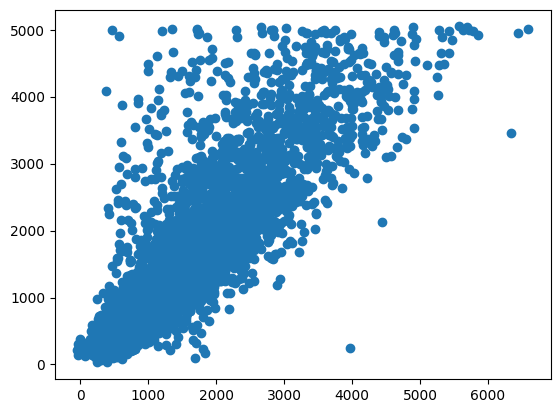

In [101]:
plt.scatter(y_pred,y_train)

- An overall linear pattern is visible with spread. So the condition of linearity is satisfied.

### 3. Residuals Normality Check


c:\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x400 with 0 Axes>

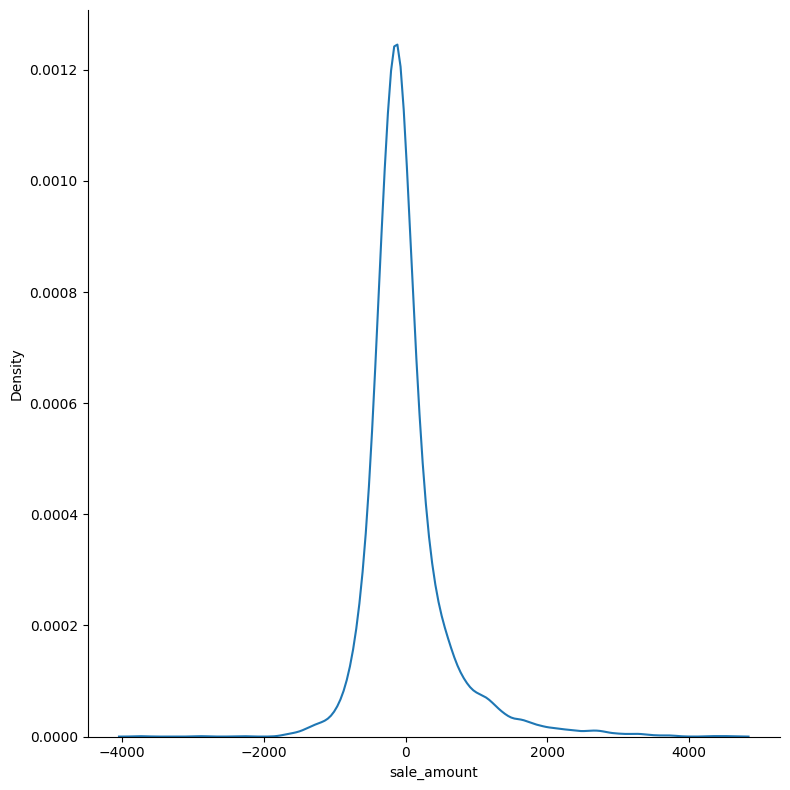

In [102]:
plt.figure(figsize=(12,4))
sns.displot(residual,kind='kde',height=8)
plt.show()

- Hence the condition of residuals normality has been met.

### 4. Homoescadasticity

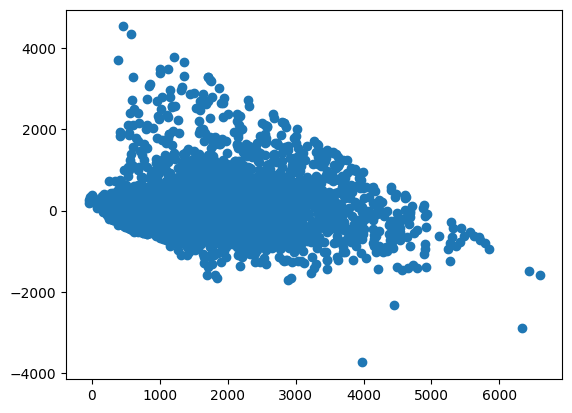

In [103]:
plt.scatter(y_pred,residual)

- The spread of predictions with residuals does not seem to follow any funnel like pattern but it does show clustering of points hence there could be presence of heteroscedasticity.

Lets verify using *Breusch pagan* test, a very powerful and commonly used test to assess the homogeniety in regression model.

In [104]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Fit linear regression model
X = sm.add_constant(X_train) 
model = sm.OLS(y_train, X)
results=model.fit()
# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(results.resid, results.model.exog)

# Extract the test statistics and p-value
test_statistic = bp_test[0]
p_value = bp_test[1]

print("Breusch-Pagan Test Statistic:", test_statistic)
print("Breusch-Pagan Test p-value:", p_value)


Breusch-Pagan Test Statistic: 355.0592174429374
Breusch-Pagan Test p-value: 1.1703152407685476e-60


- Clearly our model fails to address Homoscedasticity in residuals.

Although all the other conditions of linear regression are fulfilled and aslo we didnt find clear funnel type scatter plot between y pred and residuals therefore it is safe to say that the presence of moderate heteroscedasticity will not severely impact our model quality and inferences.

### Model Validation
Verifying the model performance to conclude the robustness of the model despite violation of homoscedasticity condition i.e if the model metric like mse, R sqared, on test and train are reasonably close to each other this would mean the model is robust and is not affected by the heteroscedasticity otherwise we may need to address this issue by performing transformation or put more efforts in feature engineering.

In [105]:
from sklearn.metrics import r2_score, mean_squared_error


y_pred_test=mmodel.predict(X_test)
# Calculation of MAE
mae_test= np.mean(y_test - y_pred_test)
mae_train=np.mean(y_train - y_pred)
print('Train MAE:',mae_train)
print("Test MAE:",mae_test,"\n")


# Calculate R-squared error
train_r2 = r2_score(y_train, y_pred)
test_r2 = r2_score(y_test, y_pred_test)

# Calculate Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train, y_pred)
test_mse = mean_squared_error(y_test, y_pred_test)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2,"\n")
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)



Train MAE: 1.7474280637906216e-13
Test MAE: -19.980842665413086 

Train R-squared: 0.7404754178090773
Test R-squared: 0.7226045259372316 

Train MSE: 325571.35339471366
Test MSE: 330573.20227220794


Hence the model is able to generalize well on holdout data although the model's ability to explain the variability in sales is 73%. And in general the R squared score above 70% is considered reasonable to indicate driving factors in sales and help make informed decisions.

## Building OLS model 

In [106]:
'''Creating OLS model from scipy for detailed summary of our model.'''

import statsmodels.formula.api as smf
import statsmodels.api as sm

X1.shape,y1.shape

((6832, 24), (6832,))

In [107]:
# Add a constant to the feature matrix
X_train_with_const = sm.add_constant(X_train)

# Create an OLS model
ols_model = sm.OLS(y_train, X_train_with_const)

# Fit the model
ols_results = ols_model.fit()

# Print the summary of the OLS regression results
print(ols_results.summary())


                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     646.7
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:13:09   Log-Likelihood:                -42439.
No. Observations:                5465   AIC:                         8.493e+04
Df Residuals:                    5440   BIC:                         8.509e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

dropping the feature one by one whose p value is above 0.05 i.e the said feature's coef is statistically equal to zero i.e the feature fails to explain varability in target variable hence dropping it. 

In [109]:
# Dropping column having P-value>0.05
def drop_var(mod):
    q = mod.pvalues.drop('const')[mod.pvalues>0.05].sort_values(ascending=False).index[0]
    return q

In [110]:
# Model-2
X_train_with_const = X_train_with_const.drop(drop_var(ols_results), axis = 1)
print("feature dropped:",drop_var(ols_results),"\n")
ols_model = sm.OLS(y_train, X_train_with_const)

# Fit the model
ols_results_2 = ols_model.fit()

# Print the summary of the OLS regression results
print(ols_results_2.summary())

feature dropped: cat_prod_cnt_Food 

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     675.0
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:13:53   Log-Likelihood:                -42439.
No. Observations:                5465   AIC:                         8.493e+04
Df Residuals:                    5441   BIC:                         8.508e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [111]:
# Model-3
X_train_with_const = X_train_with_const.drop(drop_var(ols_results_2), axis = 1)
print("feature dropped:",drop_var(ols_results_2),"\n")
ols_model = sm.OLS(y_train, X_train_with_const)

# Fit the model
ols_results_3 = ols_model.fit()

# Print the summary of the OLS regression results
print(ols_results_3.summary())

feature dropped: cat_pen_HH_Electrical 

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     705.4
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:14:13   Log-Likelihood:                -42440.
No. Observations:                5465   AIC:                         8.493e+04
Df Residuals:                    5442   BIC:                         8.508e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

Now all the variables have p values less than 0.05 hence the model-3 is our optimal model.


## Identifying the key drivers for sales

- To find the relative effect size or impact of each predictor on our target variable we will perform standardization on our x_train and y_train.
- By doing this we will be able to quantify the impact of each predictors on the target variable as all the variables in the analysis will be on same scale or z scale. Hence making it easier to comment on if a unit SD change occurs on a predictor how will the sales be affected by that change if rest of the predictors were kept constant.

In [113]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
# Fit and transform features
X_train_scaled = scaler_X.fit_transform(X_train_with_const)

# Create a StandardScaler object for target variable
scaler_y = StandardScaler()
# Reshape y_train to a 2D array as StandardScaler expects a 2D array
y_train_reshaped = y_train.values.reshape(-1, 1)
# Fit and transform target variable
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)

In [114]:
X_train_scaled=pd.DataFrame(X_train_scaled,columns=X_train_with_const.columns)
X_train_scaled

,const,no_baskets_Promo,discount,cat_prod_cnt_Mother_Child,no_baskets_weekday,no_Promo_prods,cat_prod_cnt_Drinks,cat_prod_cnt_Kitchen_Clean,Products_with_discount,cat_prod_cnt_Beauty,...,cat_prod_cnt_HH_Electrical,no_baskets_weekend,cat_pen_Kitchen_Clean,cat_pen_Drinks,cat_pen_Beauty,cat_pen_Food,cat_pen_Home,cat_pen_Mother_Child,cat_prod_cnt_Mobiles,cat_pen_Mobiles
0,0.000,-1.080,-0.566,-0.364,-1.070,-0.801,-0.730,-0.759,-0.592,-0.849,...,-0.497,-0.485,-1.332,-1.243,-1.353,-1.697,-0.631,-0.513,-0.196,-0.161
1,0.000,-1.080,1.168,0.711,-0.133,-0.801,-0.730,-0.759,-0.341,-0.152,...,-0.497,-0.938,-1.332,-1.243,0.670,-1.697,-0.631,2.304,-0.196,-0.161
2,0.000,3.655,2.822,-0.149,1.508,9.590,3.860,-0.303,4.817,-0.650,...,0.419,1.326,-0.384,1.699,-0.957,1.361,-0.631,-0.237,-0.196,-0.161
3,0.000,1.148,0.634,-0.149,0.805,1.187,0.532,0.001,-0.047,1.242,...,-0.497,1.326,-0.641,0.424,0.092,0.856,-0.631,-0.178,-0.196,-0.161
4,0.000,-0.523,-0.366,-0.364,-0.836,-0.620,-0.500,-0.075,-0.466,-0.053,...,-0.497,-0.032,0.280,-0.410,1.176,0.740,-0.631,-0.513,-0.196,-0.161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5460,0.000,-0.802,-0.566,-0.364,-0.367,-0.711,-0.730,-0.759,-0.550,-0.252,...,-0.497,-0.938,-1.332,-1.243,0.333,-1.697,1.010,-0.513,-0.196,-0.161
5461,0.000,-0.523,-0.299,0.711,-1.070,-0.530,-0.730,-0.075,-0.508,-0.750,...,-0.497,0.421,1.085,-1.243,-0.510,-0.885,1.010,1.834,-0.196,-0.161
5462,0.000,-0.245,-0.566,-0.364,-0.836,-0.169,-0.156,-0.227,-0.592,-0.152,...,-0.497,-0.032,1.085,1.257,1.176,0.740,-0.631,-0.513,-0.196,-0.161
5463,0.000,1.148,0.928,-0.149,1.976,0.374,-0.386,1.141,2.008,-0.053,...,-0.497,0.874,0.459,-0.873,-0.604,0.830,0.463,-0.252,-0.196,-0.161


In [115]:
X_train_scaled.drop(columns=['const'],inplace=True)

In [116]:

# Add a constant to the feature matrix
X_train_with_const = sm.add_constant(X_train_scaled)

# Create an OLS model
ols_model = sm.OLS(y_train_scaled, X_train_with_const)

# Fit the model
ols_results_final = ols_model.fit()

# Print the summary of the OLS regression results
print(ols_results_final.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     705.4
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:14:45   Log-Likelihood:                -4069.8
No. Observations:                5465   AIC:                             8186.
Df Residuals:                    5442   BIC:                             8338.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [117]:
# Acquiring beta coeffs of predictors and their p values
all_pred_df=pd.DataFrame({'beta_coef_standardize':ols_results_final.params,'P values':ols_results_final.pvalues},index=ols_results_final.pvalues.index)
all_pred_df=all_pred_df.reset_index()
all_pred_df

,index,beta_coef_standardize,P values
0,const,0.000,1.000
1,no_baskets_Promo,-0.046,0.021
2,discount,0.124,0.000
3,cat_prod_cnt_Mother_Child,0.087,0.000
4,no_baskets_weekday,0.297,0.000
5,no_Promo_prods,0.033,0.018
6,cat_prod_cnt_Drinks,-0.046,0.001
7,cat_prod_cnt_Kitchen_Clean,0.108,0.000
8,Products_with_discount,-0.151,0.000
9,cat_prod_cnt_Beauty,0.062,0.000


## Top product categories as drivers of sales

In [118]:
all_pred_df[(all_pred_df['index'].str.contains('cat_prod_cnt')) & (all_pred_df['beta_coef_standardize']>0)].sort_values(by='beta_coef_standardize',ascending=False)

,index,beta_coef_standardize,P values
7,cat_prod_cnt_Kitchen_Clean,0.108,0.000
3,cat_prod_cnt_Mother_Child,0.087,0.000
9,cat_prod_cnt_Beauty,0.062,0.000
13,cat_prod_cnt_HH_Electrical,0.060,0.000
21,cat_prod_cnt_Mobiles,0.034,0.004
12,cat_prod_cnt_Home,0.028,0.006


In [125]:
y_train.std()

1120.1432856410288

Among all the product category 'Kitchen_Clean' category is driving the sales more than the rest of the categories. Basically if 1 Std rise occurs in count of products sold in 'Kitchen_Clean' category leads to 0.108 Std rise in sales amount.

1 std of cat_prod_cnt_Kitchen_Clean= 13.16
1 std of sale_amount= 1120.14

so for the rise of 13.16 units of products in this category, will lead to rise in sales by 0.108*1120.14 = 120.14 if all the predictors are kept constant.

In [123]:
def fun(predictor):
    if predictor!='const':
        return np.std(X_train.loc[:,predictor])
    else:
        pass
all_pred_df['Std']=all_pred_df['index'].apply(fun)

In [124]:
all_pred_df

,index,beta_coef_standardize,P values,Std
0,const,0.000,1.000,NaN
1,no_baskets_Promo,-0.046,0.021,3.590
2,discount,0.124,0.000,74.992
3,cat_prod_cnt_Mother_Child,0.087,0.000,4.650
4,no_baskets_weekday,0.297,0.000,4.267
5,no_Promo_prods,0.033,0.018,11.067
6,cat_prod_cnt_Drinks,-0.046,0.001,8.715
7,cat_prod_cnt_Kitchen_Clean,0.108,0.000,13.159
8,Products_with_discount,-0.151,0.000,23.849
9,cat_prod_cnt_Beauty,0.062,0.000,10.042


In [126]:
all_pred_df['sale_amount_std']=np.std(y_train)
all_pred_df['Rise/Drop_in_sales']=all_pred_df['beta_coef_standardize']* all_pred_df['sale_amount_std']
all_pred_df

,index,beta_coef_standardize,P values,Std,sale_amount_std,Rise/Drop_in_sales
0,const,0.000,1.000,NaN,1120.041,0.000
1,no_baskets_Promo,-0.046,0.021,3.590,1120.041,-51.121
2,discount,0.124,0.000,74.992,1120.041,138.689
3,cat_prod_cnt_Mother_Child,0.087,0.000,4.650,1120.041,97.354
4,no_baskets_weekday,0.297,0.000,4.267,1120.041,332.800
5,no_Promo_prods,0.033,0.018,11.067,1120.041,37.374
6,cat_prod_cnt_Drinks,-0.046,0.001,8.715,1120.041,-51.824
7,cat_prod_cnt_Kitchen_Clean,0.108,0.000,13.159,1120.041,120.821
8,Products_with_discount,-0.151,0.000,23.849,1120.041,-168.888
9,cat_prod_cnt_Beauty,0.062,0.000,10.042,1120.041,69.283


## Conclusions & Recommendations:
1. Among all the product category 'Mother_child','Kitchen_Clean','Beauty' are the top three category which are driving the sales more than the rest of the categories.
 
2. no_baskets_Promo, number of days a customer visists and make purchase on promoted products, has negative beta coefficient indicating the promoted products are unable to drive sales i.e driving loss in sales. It indicates the need to improve marketing strategies, need to do deeper analysis on what to promote and what not to promote.
3. The sales can be expected to rise by 143 if a customer makes purchase from 2 distinct categories.

Using these conclusions and the all_pred_df dataframe various other business decisions can be made.